In [2]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp


from keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, Input, Permute, Concatenate

from training import train, create_training_folder


In [3]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [4]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [5]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 8]
X = sample[:, 0:8]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)
# random train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# y_train = to_categorical(y_train, num_classes=vocab_size)
# y_test = to_categorical(y_test, num_classes=vocab_size)

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31015, 9)
(2,)
===Train/test size: 21710, 9305


In [6]:
y.shape

(31015, 27)

In [7]:
crop_names = df_crops["description"].values.tolist()
crop_names

['TRIGO',
 'URBANO-VIALES',
 'MAIZ',
 'CEBADA',
 'OTROS CEREALES',
 'ROQUEDOS',
 'SUELO DESNUDO',
 'GIRASOL',
 'COLZA',
 'OTRAS LEGUMINOSAS GRANO',
 'GUISANTES',
 'ALFALFA',
 'FORRAJERAS',
 'OTROS CULTIVOS INDUSTRIALES',
 'REMOLACHA',
 'VIÑEDO',
 'OLIVAR',
 'HORTICOLA',
 'AROMATICAS',
 'FRUTALES',
 'FRUTALES CASCARA',
 'PASTIZAL',
 'MATORRAL',
 'CONIFERAS',
 'FRONDOSAS CADUCIFOLIAS',
 'FRONDOSAS SIEMPRE VERDES',
 'LAMINA AGUA']

In [8]:
np.unique(X)
np.unique(y)

df_crops

model = load_model('../results/20200719_181629_lstm_64_64')


In [9]:
y_pred = model.predict(X_test)

class_test = np.argmax(y_test, axis=1)
class_predicted = np.argmax(y_pred, axis=1)

# eval_model(folder, class_predicted, class_test, classes, labels)
np.unique(class_predicted)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

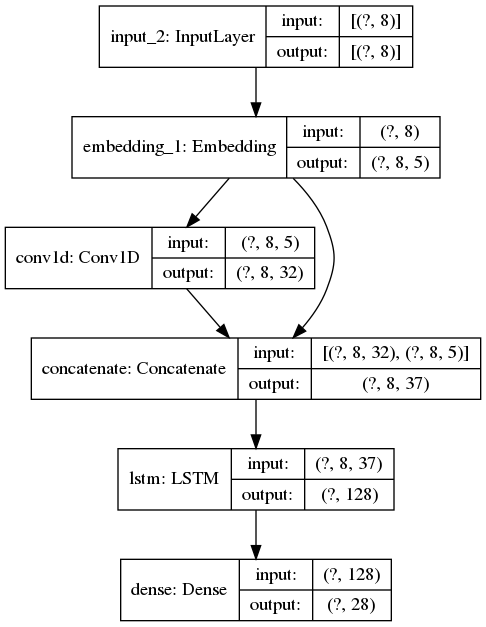

In [25]:
sequence_length = 8
vocab_size, embedding_size = (28, 5)

K.clear_session()

layer_size = 128

input = Input(shape=(sequence_length,)) 

# embeddings = Embedding(vocab_size, embedding_size,input_length=sequence_length)

embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input) 

input = Input(shape=(sequence_length,))

embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

model.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(Permute((2, 1)))

    
conv1 = Conv1D(filters=32, kernel_size=2, padding="same", strides=1, activation='relu')(embeddings)
conv2 = Conv1D(filters=32, kernel_size=2, padding="same", strides=1, activation='relu')(conv1)
# # conv3 = Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation='relu')(embeddings)
# lstm1 = LSTM(64, dropout=0.3, recurrent_dropout=0.2, return_sequences = True)(embeddings)

concat = Concatenate(axis=2)([conv1, embeddings])
lstm = LSTM(layer_size, dropout=0.3, recurrent_dropout=0.2)(concat)

output = Dense(vocab_size, activation='relu')(lstm)
model = Model(input, output, name="conv-lstm_parallel")

plot_model(model, show_shapes = True)

In [22]:
K.clear_session()

sequence_length = 8

vocab_size, embedding_size = (28, 5)
layer_size = (64, 32)
final_activation = "relu"

model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=sequence_length))
return_sequences = True
for i, units in enumerate(layer_size):
    if i == len(layer_size) - 1:  # last layer
        return_sequences = False
    model.add(LSTM(units, dropout=0.3, recurrent_dropout=0.4,
                   activation='relu', return_sequences=return_sequences))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation=final_activation))
tag = "conv_lstm_128_64"

In [26]:
training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)


In [27]:
epochs=100

folder = create_training_folder(tag)

lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)

# evaluate
y_hat = model.predict(X_test)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)


Epoch 1/100


ValueError: in user code:

    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /home/gus/workspaces/wpy/IACapstone/src/metrics.py:20 f1_loss
        tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:1283 _mul_dispatch
        return gen_math_ops.mul(x, y, name=name)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py:6092 mul
        "Mul", x=x, y=y, name=name)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 27 and 28 for '{{node f1_loss/mul}} = Mul[T=DT_FLOAT](IteratorGetNext:1, conv-lstm_parallel/dense/Relu)' with input shapes: [?,27], [?,28].
